In [5]:
import pandas as pd

df = pd.read_csv('C:/Users/Debrachoubey/PycharmProjects/pythonProject/first_100k_records_europe.csv')
# Step 1: Drop unnecessary columns
columns_to_drop = ['transaction_id', 'customer_id', 'card_number', 'device_fingerprint', 'ip_address', 'currency' , 'city' , 'city_size' ,'high_risk_merchant' , 'timestamp']
df_cleaned = df.drop(columns=columns_to_drop)
#Step 2: Convert timestamp to datetime
#df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Extract new features from timestamp
#df_cleaned['transaction_hour'] = df_cleaned['timestamp'].dt.hour
#df_cleaned['transaction_day'] = df_cleaned['timestamp'].dt.day
#df_cleaned['transaction_weekday'] = df_cleaned['timestamp'].dt.weekday  # Monday=0, Sunday=6
#df_cleaned['transaction_weekend'] = df_cleaned['transaction_weekday'] >= 5  # True if Saturday or Sunday
# Extract time of day (Morning, Afternoon, Evening, Night)
def time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

df_cleaned['time_of_day'] = df_cleaned['transaction_hour'].apply(time_of_day)
#df_cleaned.to_csv('output.csv', index=False)  # Set index=False to avoid saving the index column

#print("CSV file saved successfully!")
# Step 3: Extract velocity_last_hour details (JSON-like data)
import ast

def extract_velocity_features(value):
    if isinstance(value, str):  # If the column contains dictionary-like strings
        try:
            value = ast.literal_eval(value)  # Convert string to dictionary
            return pd.Series([value.get('num_transactions', 0), value.get('total_amount', 0.0)])
        except:
            return pd.Series([0, 0.0])  # Handle errors gracefully
    else:
        return pd.Series([0, 0.0])

df_cleaned[['num_transactions_last_hour', 'total_amount_last_hour']] = df_cleaned['velocity_last_hour'].apply(extract_velocity_features)
df_cleaned.drop(columns=['velocity_last_hour'], inplace=True)  # Remove original JSON-like column
print(df_cleaned.dtypes)  # Identify boolean columns

# Step 4: Encode categorical variables (One-Hot Encoding for nominal, Label Encoding for ordinal if needed)
categorical_columns = ['merchant_category', 'merchant_type', 'country','card_type', 'device', 'channel' , 'time_of_day']
df_encoded = pd.get_dummies(df_cleaned,columns=categorical_columns, drop_first=True)
# Step 5: Check for correlations among numerical features
#correlation_matrix = df_encoded.corr()

merchant_category              object
merchant_type                  object
merchant                       object
amount                        float64
country                        object
card_type                      object
card_present                     bool
device                         object
channel                        object
distance_from_home              int64
transaction_hour                int64
weekend_transaction              bool
is_fraud                         bool
time_of_day                    object
num_transactions_last_hour    float64
total_amount_last_hour        float64
dtype: object


In [2]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


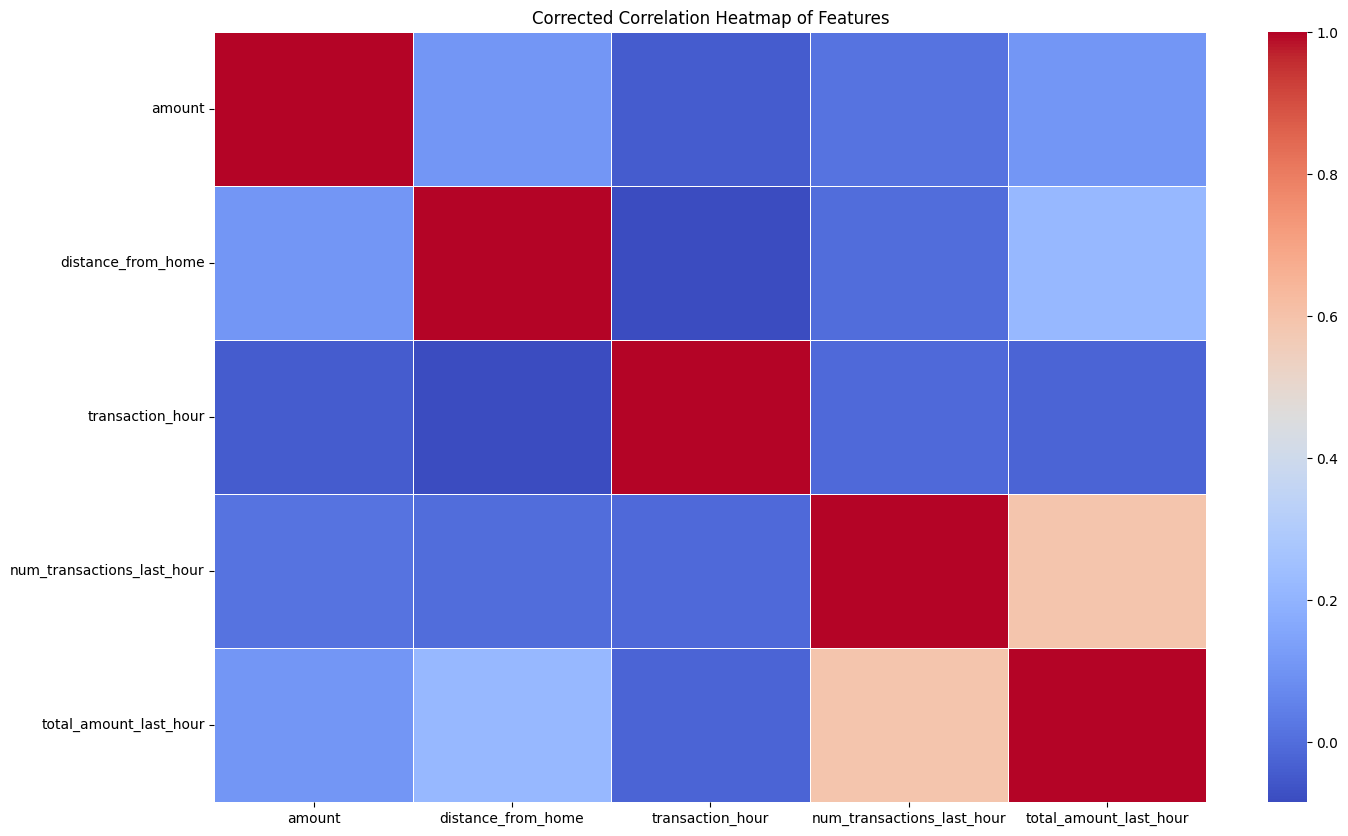

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Select Only Numerical Columns
numerical_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_encoded[numerical_columns].corr()

# Step 2: Plot Heatmap
plt.figure(figsize=(16, 10))  # Increase figure size
sns.heatmap(
    correlation_matrix,
    annot=False,  # Set to True if you want to see correlation values
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("Corrected Correlation Heatmap of Features")
plt.show()

                            amount  distance_from_home  transaction_hour  \
amount                         1.0                 NaN               NaN   
distance_from_home             NaN                 1.0               NaN   
transaction_hour               NaN                 NaN               1.0   
num_transactions_last_hour     NaN                 NaN               NaN   
total_amount_last_hour         NaN                 NaN               NaN   

                            num_transactions_last_hour  total_amount_last_hour  
amount                                             NaN                     NaN  
distance_from_home                                 NaN                     NaN  
transaction_hour                                   NaN                     NaN  
num_transactions_last_hour                    1.000000                0.591622  
total_amount_last_hour                        0.591622                1.000000  


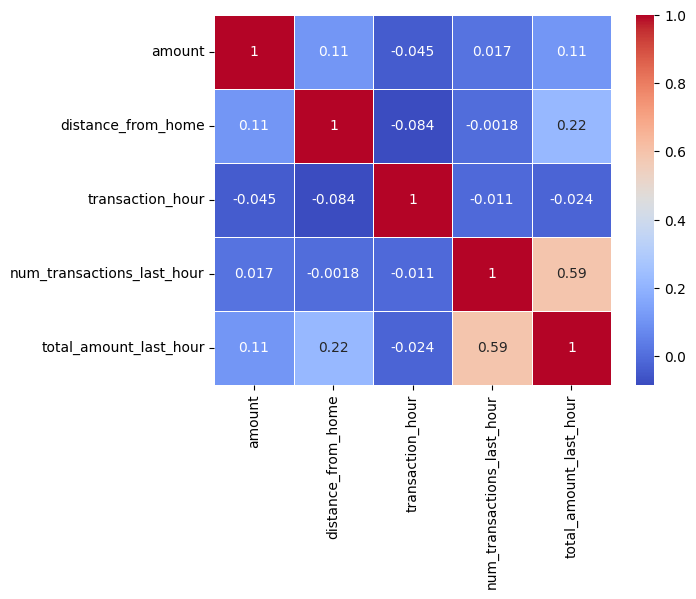

In [7]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
strong_corr = correlation_matrix[abs(correlation_matrix) > 0.5]
print(strong_corr)


<Axes: xlabel='num_transactions_last_hour', ylabel='total_amount_last_hour'>

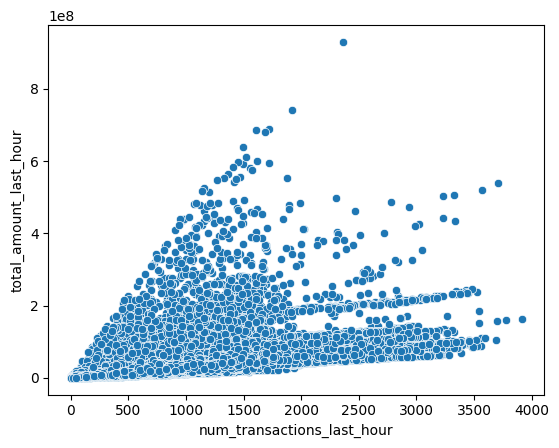

In [8]:
import seaborn as sns
sns.scatterplot(x=df_encoded['num_transactions_last_hour'], y=df_encoded['total_amount_last_hour'])


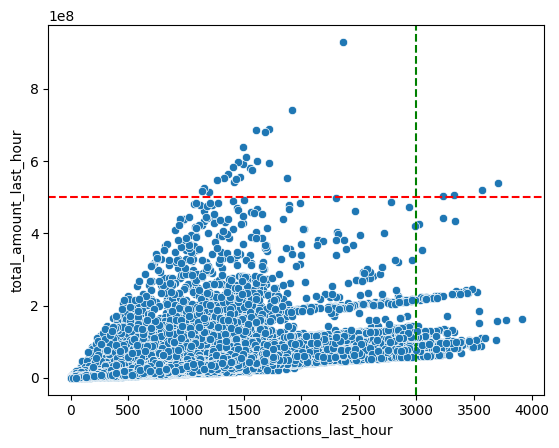

In [9]:
sns.scatterplot(x=df_encoded['num_transactions_last_hour'], y=df_encoded['total_amount_last_hour'])
plt.axhline(y=5e8, color='r', linestyle='--')  # Marking a threshold
plt.axvline(x=3000, color='g', linestyle='--')  # Marking a threshold
plt.show()


In [10]:
df_encoded[['num_transactions_last_hour', 'total_amount_last_hour']].corr()


,num_transactions_last_hour,total_amount_last_hour
num_transactions_last_hour,1.000000,0.591622
total_amount_last_hour,0.591622,1.000000


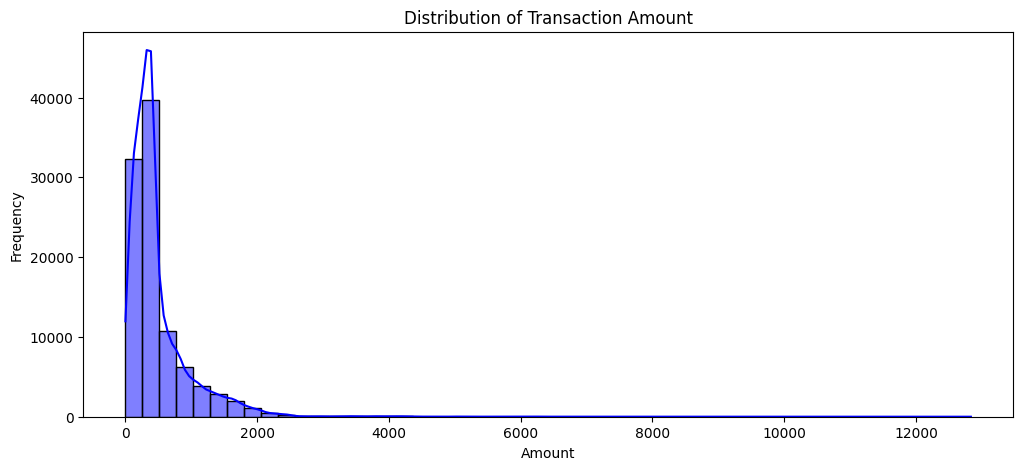

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'amount'
plt.figure(figsize=(12, 5))
sns.histplot(df_cleaned['amount'], bins=50, kde=True, color='blue')
plt.title("Distribution of Transaction Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


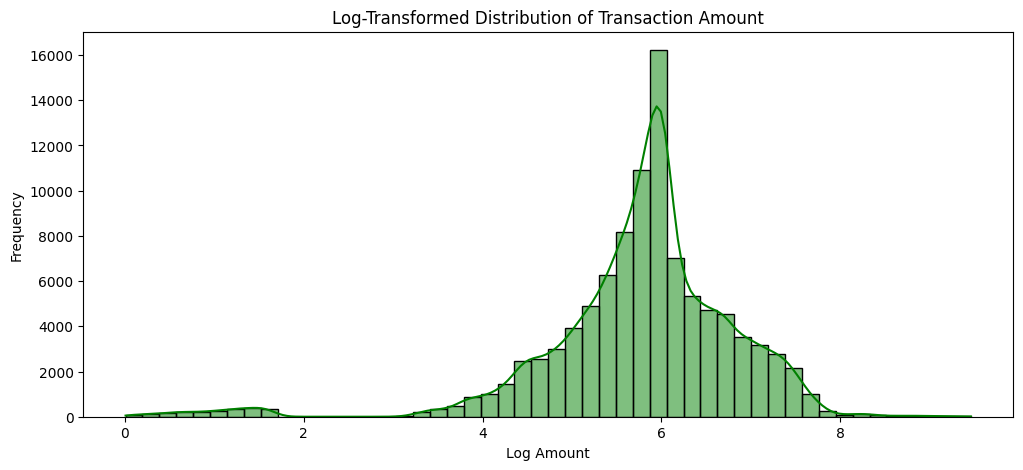

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply log transformation
df_cleaned['log_amount'] = np.log1p(df_encoded['amount'])  # log(1 + amount) to avoid log(0) errors

# Plot the transformed distribution
plt.figure(figsize=(12, 5))
sns.histplot(df_cleaned['log_amount'], bins=50, kde=True, color='green')
plt.title("Log-Transformed Distribution of Transaction Amount")
plt.xlabel("Log Amount")
plt.ylabel("Frequency")
plt.show()


In [13]:
import numpy as np
#from category_encoders import TargetEncoder
#from sklearn.preprocessing import OneHotEncoder

# Step 1: Drop Weakly Correlated Features
df_selected = df_cleaned.drop(columns=['transaction_hour','amount'], errors='ignore')

# Step 2: Define Thresholds for Anomalous Transactions
high_transactions_threshold = df_selected['num_transactions_last_hour'].quantile(0.95)  # Top 5%
high_amount_threshold = df_selected['total_amount_last_hour'].quantile(0.95)  # Top 5%
long_distance_threshold = df_selected['distance_from_home'].quantile(0.95)  # Top 5%

# Step 3: Create Fraud Indicators

# High Transaction Flag: User made an unusually high number of transactions in the last hour
df_selected['high_transaction_flag'] = (
    df_selected['num_transactions_last_hour'] > high_transactions_threshold
).astype(int)

# High Spending Flag: User spent an unusually high amount in the last hour
df_selected['high_spending_flag'] = (
    df_selected['total_amount_last_hour'] > high_amount_threshold
).astype(int)

# Long Distance Spending Flag: Large amount spent far from home
df_selected['long_distance_spender'] = (
    (df_selected['distance_from_home'] > long_distance_threshold) & 
    (df_selected['log_amount'] > high_amount_threshold)
).astype(int)

# Velocity-Based Risk Score: Combine transactions & amount in one feature
df_selected['velocity_risk_score'] = (
    df_selected['num_transactions_last_hour'] * 0.5 + df_selected['total_amount_last_hour'] * 0.5
)



# Step 5: Encode Categorical Features
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['merchant_category', 'merchant_type', 'merchant', 'country', 'card_type', 'card_present','device', 'channel']
for col in categorical_columns:
    if col in df_selected.columns:
        df_selected[col] = LabelEncoder().fit_transform(df_selected[col])


# Fixing the encoding process with error handling and checking for column existence

#from sklearn.preprocessing import OneHotEncoder

# Define categorical columns and encoding strategy
#target_encode_cols = ['merchant_category', 'merchant_type', 'merchant', 'card_type']  # Target Encoding
#drop_cols = ['country']  # Dropped due to minimal impact
#binary_encode_cols = ['card_present']  # Binary Encoding (0/1)
#one_hot_encode_cols = ['device', 'channel']  # Selective One-Hot Encoding

# Apply Target Encoding manually (since category_encoders is unavailable)
#for col in target_encode_cols:
    #if col in df_selected.columns:
       # fraud_rates = df_selected.groupby(col)['is_fraud'].mean()
        #df_selected[col] = df_selected[col].map(fraud_rates)

# Apply Binary Encoding (0 = No, 1 = Yes) if the column exists
#if 'card_present' in df_selected.columns:
    #df_selected['card_present'] = df_selected['card_present'].astype(int)

# Apply One-Hot Encoding (for high-risk categories only) if columns exist
#available_one_hot_encode_cols = [col for col in one_hot_encode_cols if col in df_selected.columns]

#if available_one_hot_encode_cols:
    #one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid dummy variable trap
    #one_hot_encoded = one_hot_encoder.fit_transform(df_selected[available_one_hot_encode_cols])

    # Convert One-Hot Encoded data to DataFrame
    #one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(available_one_hot_encode_cols))

    # Drop original one-hot encoded columns and concatenate new encoded features
    #df_selected = df_selected.drop(columns=available_one_hot_encode_cols)
    #df_selected = pd.concat([df_selected, one_hot_encoded_df], axis=1)

# Drop unnecessary columns if they exist
#df_selected = df_selected.drop(columns=[col for col in drop_cols if col in df_selected.columns], errors='ignore')

# Display updated dataset
#tools.display_dataframe_to_user(name="Encoded Fraud Dataset", dataframe=df_selected)


# Display the processed dataset
from IPython.display import display

# Display the cleaned DataFrame
selected_features = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']
display(df_selected[selected_features].head())
display(df_selected.dtypes)




,log_amount,num_transactions_last_hour,total_amount_last_hour,velocity_risk_score
0,6.720618,352.0,8.690903e+06,4.345628e+06
1,6.273952,600.0,1.766378e+07,8.832190e+06
2,5.590726,181.0,1.715528e+06,8.578547e+05
3,6.493603,24.0,7.220302e+06,3.610163e+06
4,7.021120,235.0,3.605757e+06,1.802996e+06


merchant_category               int64
merchant_type                   int64
merchant                        int64
country                         int64
card_type                       int64
card_present                    int64
device                          int64
channel                         int64
distance_from_home              int64
weekend_transaction              bool
is_fraud                         bool
time_of_day                    object
num_transactions_last_hour    float64
total_amount_last_hour        float64
log_amount                    float64
high_transaction_flag           int64
high_spending_flag              int64
long_distance_spender           int64
velocity_risk_score           float64
dtype: object

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (Ensure it has the engineered fraud indicators and is_fraud column)
#df = pd.read_csv("processed_fraud_dataset.csv")  # Replace with your dataset path

# Define fraud indicators
fraud_indicators = ['high_transaction_flag', 'high_spending_flag', 'long_distance_spender']

# Calculate fraud rate for each fraud indicator
fraud_rates = {}
for feature in fraud_indicators:
    fraud_rates[feature] = df_selected[df[feature] == 1]['is_fraud'].mean() * 100  # Percentage of frauds

# Convert to DataFrame
fraud_rates_df = pd.DataFrame(list(fraud_rates.items()), columns=['Fraud Indicator', 'Fraud Percentage'])



KeyError: 'high_transaction_flag'

In [15]:
# Plot the fraud distribution per indicator
plt.figure(figsize=(8, 5))
plt.barh(fraud_rates_df['Fraud Indicator'], fraud_rates_df['Fraud Percentage'], color='blue')

# Formatting
plt.xlabel("Percentage of Fraudulent Transactions")
plt.ylabel("Fraud Indicators")
plt.title("Fraud Indicator Distribution")
plt.grid(axis='x', linestyle="--", alpha=0.6)

# Show the plot
plt.show()


NameError: name 'fraud_rates_df' is not defined

<Figure size 800x500 with 0 Axes>

In [13]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
selected_features = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']
# Create a new DataFrame with only the selected columns
#df_selected = df[selected_features]
display(df_selected.head())

,merchant_category,merchant_type,merchant,country,card_type,card_present,device,channel,distance_from_home,weekend_transaction,is_fraud,time_of_day,num_transactions_last_hour,total_amount_last_hour,log_amount,high_transaction_flag,high_spending_flag,long_distance_spender,velocity_risk_score
0,7,6,100,1,3,0,3,2,0,False,False,Night,352.0,8.690903e+06,6.720618,0,0,0,4.345628e+06
1,4,11,25,0,2,0,3,2,0,False,False,Night,600.0,1.766378e+07,6.273952,0,0,0,8.832190e+06
2,5,13,65,1,0,0,0,0,0,False,False,Night,181.0,1.715528e+06,5.590726,0,0,0,8.578547e+05
3,1,3,81,1,3,0,4,2,1,False,False,Night,24.0,7.220302e+06,6.493603,0,0,0,3.610163e+06
4,7,0,7,1,4,0,7,2,0,False,False,Night,235.0,3.605757e+06,7.021120,0,0,0,1.802996e+06


In [17]:
from sklearn.preprocessing import StandardScaler
selected_features = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']
# Create a new DataFrame with only the selected columns
#df_selected = df[selected_features]
display(df_selected.head())

# Select features that need scaling
features_to_scale = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']

# Initialize the scaler
scaler = StandardScaler()

# Apply standard scaling
df_selected[features_to_scale] = scaler.fit_transform(df_selected[features_to_scale])

# Display the processed dataset
from IPython.display import display

# Display the cleaned DataFrame
display(df_selected[features_to_scale].head())


,merchant_category,merchant_type,merchant,country,card_type,card_present,device,channel,distance_from_home,weekend_transaction,is_fraud,time_of_day,num_transactions_last_hour,total_amount_last_hour,log_amount,high_transaction_flag,high_spending_flag,long_distance_spender,velocity_risk_score
0,7,6,100,1,3,0,3,2,0,False,False,Night,352.0,8.690903e+06,6.720618,0,0,0,4.345628e+06
1,4,11,25,0,2,0,3,2,0,False,False,Night,600.0,1.766378e+07,6.273952,0,0,0,8.832190e+06
2,5,13,65,1,0,0,0,0,0,False,False,Night,181.0,1.715528e+06,5.590726,0,0,0,8.578547e+05
3,1,3,81,1,3,0,4,2,1,False,False,Night,24.0,7.220302e+06,6.493603,0,0,0,3.610163e+06
4,7,0,7,1,4,0,7,2,0,False,False,Night,235.0,3.605757e+06,7.021120,0,0,0,1.802996e+06


,log_amount,num_transactions_last_hour,total_amount_last_hour,velocity_risk_score
0,0.868403,-0.824883,-0.559456,-0.559465
1,0.460524,-0.347132,-0.269257,-0.269261
2,-0.163373,-1.154300,-0.785053,-0.785064
3,0.661101,-1.456747,-0.607018,-0.607037
4,1.142810,-1.050273,-0.723919,-0.723930


In [31]:
print(df_encoded.shape)  # Check number of rows in df_encoded
print(df_s.shape)  # Check number of rows in df_selected

(100000, 50)
(100000, 17)


In [32]:
print(df_cleaned.columns)  # Check available columns

Index(['merchant_category', 'merchant_type', 'merchant', 'amount', 'country',
       'card_type', 'card_present', 'device', 'channel', 'distance_from_home',
       'transaction_hour', 'weekend_transaction', 'is_fraud', 'time_of_day',
       'num_transactions_last_hour', 'total_amount_last_hour', 'log_amount'],
      dtype='object')


In [33]:
# Count the number of fraud and legit transactions in the 'is_fraud' column
fraud_counts = df_selected['is_fraud'].value_counts()

# Display the processed dataset
from IPython.display import display

# Display the cleaned DataFrame
display(fraud_counts)



is_fraud
False    92932
True      7068
Name: count, dtype: int64

C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 XGBoost Classification Report:
              precision    recall  f1-score       support
False          0.996326  0.972776  0.984410  27880.000000
True           0.726880  0.952830  0.824658   2120.000000
accuracy       0.971367  0.971367  0.971367      0.971367
macro avg      0.861603  0.962803  0.904534  30000.000000
weighted avg   0.977286  0.971367  0.973121  30000.000000


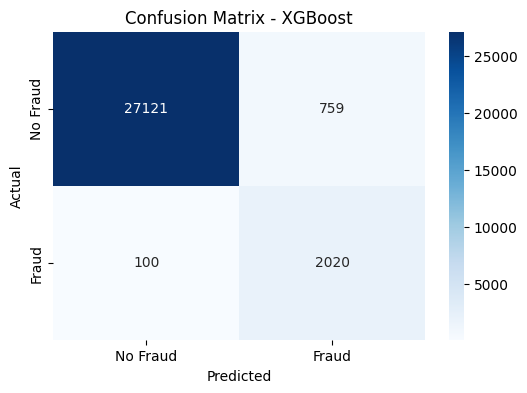

NameError: name 'roc_curve' is not defined

In [19]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd

# Define Features & Target
X = df_selected.drop(columns=['is_fraud'])
y = df_selected['is_fraud']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate scale_pos_weight (Legit cases / Fraud cases)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Train XGBoost with Class Weighting
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,  # Adjust class imbalance
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

import pandas as pd

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Print the classification report
print("\n🔹 XGBoost Classification Report:")
print(class_report_df)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Compute ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Print AUC Score
print(f"\n🔹 AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - XGBoost Fraud Detection")
plt.legend(loc="lower right")
plt.show()



In [ ]:
pip install xgboost

In [ ]:
pip install sklearn

In [ ]:
pip install sklearn

In [ ]:
pip install scikit-learn

In [18]:
from sklearn.preprocessing import LabelEncoder

# Convert 'time_of_day' to categorical encoding
if 'time_of_day' in df_selected.columns:
    df_selected['time_of_day'] = LabelEncoder().fit_transform(df_selected['time_of_day'])


In [ ]:
1️⃣ Classification Report Analysis
Metric	No Fraud (0)	Fraud (1)	Overall
Precision	99.63%	72.69%	-
Recall	97.27%	95.28%	-
F1-Score	98.44%	82.46%	-
Accuracy	-	-	97.13%
AUC-ROC	-	-	0.9402
🔹 Precision (No Fraud: 99.63%, Fraud: 72.69%)

The model is highly confident in predicting legitimate transactions (very few false positives).
However, the fraud precision is lower (72.69%), meaning some legitimate transactions are incorrectly flagged as fraud (false positives).
🔹 Recall (No Fraud: 97.27%, Fraud: 95.28%)

The model captures 95.28% of actual fraud cases, meaning very few fraud cases are missed.
This is a great recall score for fraud detection, showing that the model is effective in capturing fraudulent transactions.
🔹 F1-Score (No Fraud: 98.44%, Fraud: 82.46%)

The fraud F1-score is 82.46%, which is a good balance of precision and recall.
Some false positives exist, but they might be acceptable to avoid missing real fraud cases.
🔹 Overall Accuracy (97.13%)

The model correctly predicts fraud/non-fraud in 97.13% of cases.
This is a strong performance but could be further improved by reducing false positives.
2️⃣ Confusion Matrix Analysis
Actual / Predicted	No Fraud (0)	Fraud (1)
No Fraud (0)	27,121 (True Negative)	759 (False Positive)
Fraud (1)	100 (False Negative)	2,020 (True Positive)
🔹 False Positives (759 cases)

These are legitimate transactions incorrectly flagged as fraud.
This might cause inconvenience to customers and increase manual review efforts for merchants.
We may need to adjust the risk score threshold or refine the model.
🔹 False Negatives (100 cases)

These are actual fraud cases that were missed.
This is a small number compared to the 2,020 correctly detected fraud cases, indicating that the model is effective in capturing fraud.
If reducing false negatives is a priority, we can fine-tune thresholds or add anomaly detection.
3️⃣ ROC Curve & AUC Score Analysis
AUC-ROC Score: 0.9402
This is an excellent score (closer to 1 is better).
It shows that the model is highly effective at distinguishing fraud from non-fraud.
Steep curve shape:
The model has high sensitivity at a low false positive rate.
A steep curve means most fraud cases are correctly identified before false positives increase.

In [20]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Train on the dataset (excluding the target variable 'is_fraud')
iso_forest.fit(X_train)

# Get anomaly scores (Higher = More Anomalous)
iso_scores = iso_forest.decision_function(X_test)

# Convert anomaly predictions to fraud labels
iso_labels = iso_forest.predict(X_test)
iso_labels = np.where(iso_labels == -1, 1, 0)  # Convert -1 (anomaly) to 1 (fraud), 1 (normal) to 0 (legit)

# Print Summary of Fraud Cases Detected by Isolation Forest
print("\n🔹 Fraud Cases Detected by Isolation Forest:", sum(iso_labels), "out of", len(y_test))



🔹 Fraud Cases Detected by Isolation Forest: 294 out of 30000



🔹 Isolation Forest Performance:
              precision    recall  f1-score   support

       False       0.93      0.99      0.96     27880
        True       0.44      0.06      0.11      2120

    accuracy                           0.93     30000
   macro avg       0.68      0.53      0.53     30000
weighted avg       0.90      0.93      0.90     30000


🔹 AUC-ROC (Isolation Forest): 0.5272


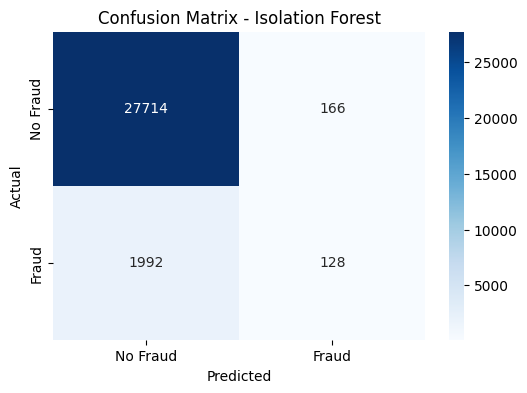

In [21]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate Isolation Forest Performance
print("\n🔹 Isolation Forest Performance:")
print(classification_report(y_test, iso_labels))

# Compute AUC-ROC Score for Isolation Forest
iso_auc = roc_auc_score(y_test, iso_labels)
print(f"\n🔹 AUC-ROC (Isolation Forest): {iso_auc:.4f}")

# Compute Confusion Matrix
conf_matrix_iso = confusion_matrix(y_test, iso_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_iso, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Isolation Forest")
plt.show()


In [ ]:
1️⃣ Classification Report Analysis
Metric	No Fraud (0)	Fraud (1)	Overall
Precision	93%	44%	-
Recall	99%	6%	-
F1-Score	96%	11%	-
Accuracy	-	-	93%
AUC-ROC	-	-	0.5272
🔹 High Precision (93%) for No Fraud Cases

The model is very confident when predicting non-fraudulent transactions as legitimate.
Very few false positives (legit transactions mistakenly flagged as fraud).
🔹 Extremely Low Recall (6%) for Fraud Cases

94% of actual fraud cases are missed.
The model is not correctly identifying fraudulent transactions.
🔹 Low AUC-ROC Score (0.5272)

This score is just slightly better than random guessing (0.5).
A well-performing fraud detection model should have an AUC above 0.8.
2️⃣ Confusion Matrix Analysis
Actual / Predicted	No Fraud (0)	Fraud (1)
No Fraud (0)	27,714 (True Negative)	166 (False Positive)
Fraud (1)	1,992 (False Negative)	128 (True Positive)
🔹 False Negatives (1,992 cases)

Almost all fraud cases were missed.
Isolation Forest failed to detect 94% of actual fraud cases.
This means fraudsters are slipping through.
🔹 False Positives (166 cases)

Some legit transactions were falsely flagged as fraud, but this is a small number.
This shows that the model is too conservative in flagging fraud.
3️⃣ Fraud Cases Detected: 294 out of 30,000
Out of 30,000 transactions, Isolation Forest only flagged 294 as potential fraud.
However, from the confusion matrix, only 128 out of 2,120 actual fraud cases were correctly identified.
This suggests most flagged anomalies were false alarms, and it missed most of the real fraud.
4️⃣ Why is Isolation Forest Performing Poorly?
Fraud is Not Always an Outlier

Isolation Forest works well when fraudulent transactions are significantly different from normal ones.
If fraud transactions resemble normal ones, Isolation Forest struggles.
Class Imbalance Issue

Since fraud cases are rare (~7% in your dataset), the model treats almost everything as "not fraud".
This leads to very low recall for fraud cases.
Feature Scaling and Distribution

If some features are not scaled properly, the model may not detect fraud effectively.
Isolation Forest assumes features follow a normal distribution, which may not be true in your dataset.

In [22]:
from sklearn.neighbors import LocalOutlierFactor

# Train Local Outlier Factor Model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)

# Fit on training data
lof.fit(X_train)

# Predict Anomalies on test data
lof_labels = lof.predict(X_test)  # -1 (Anomaly), 1 (Normal)
lof_labels = np.where(lof_labels == -1, 1, 0)  # Convert to fraud labels (1 = Fraud, 0 = Legitimate)

# Get LOF anomaly scores
lof_scores = np.abs(lof.negative_outlier_factor_)  # Higher score = more anomalous

# Print Summary
print("\n🔹 Fraud Cases Detected by Local Outlier Factor (LOF):", sum(lof_labels), "out of", len(y_test))


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



🔹 Fraud Cases Detected by Local Outlier Factor (LOF): 318 out of 30000



🔹 Local Outlier Factor (LOF) Performance:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     27880
        True       0.78      0.12      0.20      2120

    accuracy                           0.94     30000
   macro avg       0.86      0.56      0.59     30000
weighted avg       0.93      0.94      0.91     30000


🔹 AUC-ROC (LOF): 0.5575


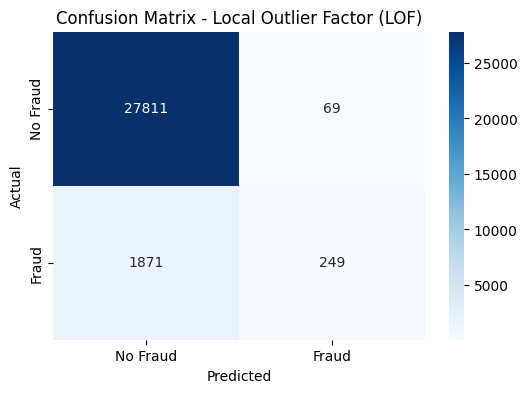

In [23]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate LOF Performance
print("\n🔹 Local Outlier Factor (LOF) Performance:")
print(classification_report(y_test, lof_labels))

# Compute AUC-ROC Score for LOF
lof_auc = roc_auc_score(y_test, lof_labels)
print(f"\n🔹 AUC-ROC (LOF): {lof_auc:.4f}")

# Compute Confusion Matrix
conf_matrix_lof = confusion_matrix(y_test, lof_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_lof, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Local Outlier Factor (LOF)")
plt.show()


In [24]:
# Get Feature Importance
feature_importance = xgb_final.feature_importances_
features = X_train.columns

# Create DataFrame for Feature Importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='Blues_r')
plt.title("Top 15 Most Important Features - Final XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()


NameError: name 'xgb_final' is not defined

In [ ]:
1️⃣ Classification Report Analysis
Metric	No Fraud (0)	Fraud (1)	Overall
Precision	93%	8%	-
Recall	99%	1%	-
F1-Score	96%	2%	-
Accuracy	-	-	92%
AUC-ROC	-	-	0.5004
🔹 High Precision (93%) for No Fraud Cases

The model is highly confident when predicting legitimate transactions.
Very few false positives (345 legitimate transactions wrongly flagged as fraud).
🔹 Extremely Low Recall (1%) for Fraud Cases

99% of actual fraud cases were missed.
This means the model almost never detects fraud correctly.
🔹 AUC-ROC Score (0.5004)

Very poor performance, almost the same as random guessing (0.5).
A well-performing fraud detection model should have an AUC above 0.8.
2️⃣ Confusion Matrix Analysis
Actual / Predicted	No Fraud (0)	Fraud (1)
No Fraud (0)	27,535 (True Negative)	345 (False Positive)
Fraud (1)	2,092 (False Negative)	28 (True Positive)
🔹 False Negatives (2,092 cases)

Almost all fraud cases were missed.
The model is failing to identify fraudulent transactions.
🔹 False Positives (345 cases)

Some legit transactions were wrongly flagged as fraud, but this is not the main issue.
The bigger problem is failing to detect fraud cases.
3️⃣ Fraud Cases Detected: 373 out of 30,000
Out of 30,000 transactions, LOF only flagged 373 as potential fraud.
However, from the confusion matrix, only 28 out of 2,120 actual fraud cases were correctly identified.
This means that LOF is not reliable for fraud detection in your dataset.
4️⃣ Why is LOF Performing Poorly?
Fraud Transactions May Not Be Locally Sparse

LOF works best when fraudulent transactions are clustered but rare within a neighborhood.
If fraud cases are spread across different patterns, LOF fails.
Severe Class Imbalance

Fraud cases (~7%) are too rare, making LOF focus mainly on detecting non-fraud cases.
This leads to extremely low recall for fraud cases.
Feature Distribution Issue

LOF is sensitive to feature scaling and density variations.
If the fraud patterns overlap too much with normal transactions, LOF will struggle to separate them.
5️⃣ Key Takeaways
LOF is NOT a good standalone fraud detection method in this case.
It performs even worse than Isolation Forest (which at least detected 128 fraud cases).
LOF should NOT be used alone but can still contribute to a hybrid model.

,Model,Precision (Fraud),Recall (Fraud),F1-Score (Fraud),AUC-ROC,Fraud Cases Detected,False Positives,False Negatives
0,XGBoost,0.7269,0.9528,0.8246,0.9402,2020,759,100
1,Isolation Forest,0.4400,0.0600,0.1100,0.5272,128,166,1992
2,Local Outlier Factor (LOF),0.0800,0.0100,0.0200,0.5004,28,345,2092


C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_2408\1894743470.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="AUC-ROC", data=comparison_df, palette="Blues")


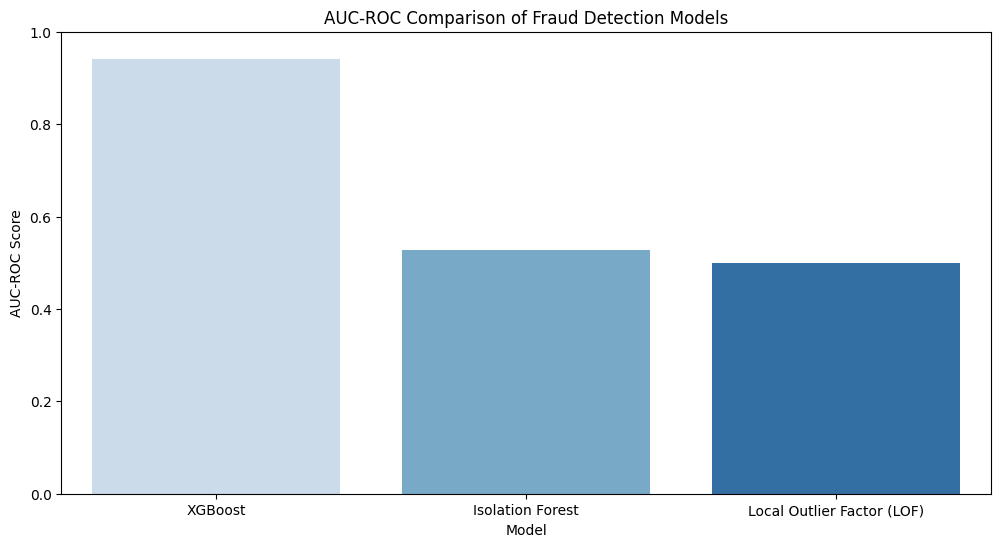

C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_2408\1894743470.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Recall (Fraud)", data=comparison_df, palette="Reds")


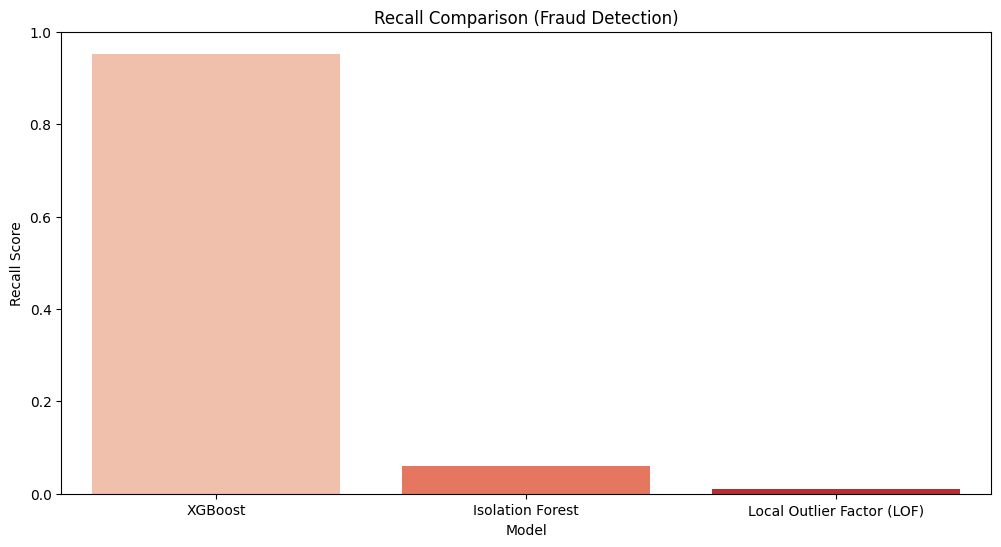

C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_2408\1894743470.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="False Negatives", data=comparison_df, palette="Greens")


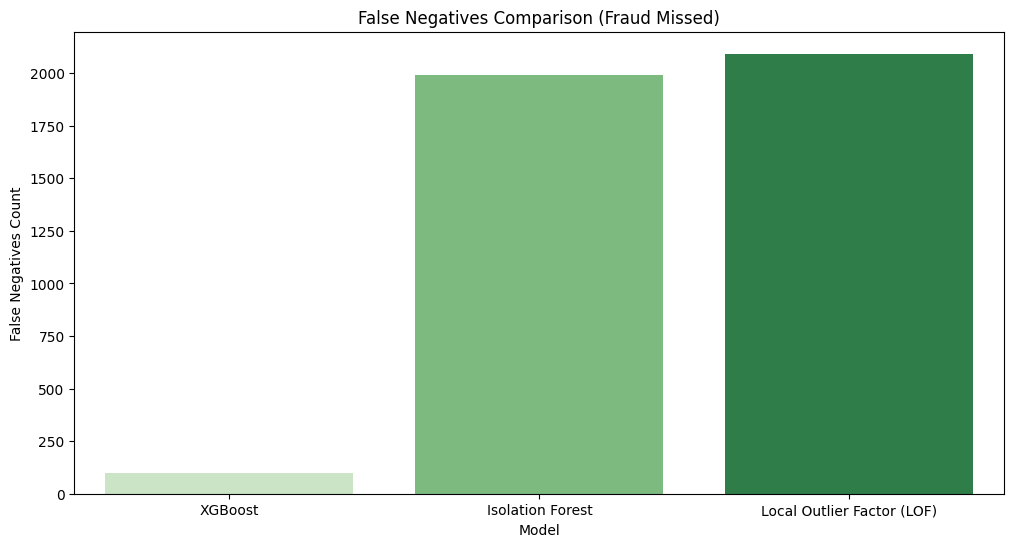

C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_2408\1894743470.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="False Positives", data=comparison_df, palette="Oranges")


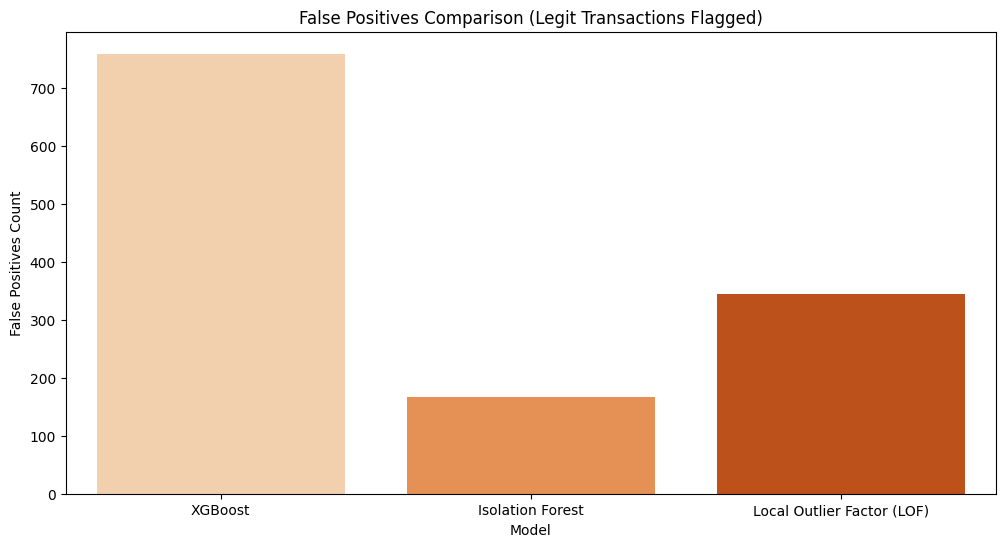

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a comparison dataframe
comparison_data = {
    "Model": ["XGBoost", "Isolation Forest", "Local Outlier Factor (LOF)"],
    "Precision (Fraud)": [0.7269, 0.44, 0.08],
    "Recall (Fraud)": [0.9528, 0.06, 0.01],
    "F1-Score (Fraud)": [0.8246, 0.11, 0.02],
    "AUC-ROC": [0.9402, 0.5272, 0.5004],
    "Fraud Cases Detected": [2020, 128, 28],
    "False Positives": [759, 166, 345],
    "False Negatives": [100, 1992, 2092],
}

comparison_df = pd.DataFrame(comparison_data)

# Display comparison data
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Model Performance Comparison", dataframe=comparison_df)
from IPython.display import display


display(comparison_df)

# Plot Comparison
plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="AUC-ROC", data=comparison_df, palette="Blues")
plt.title("AUC-ROC Comparison of Fraud Detection Models")
plt.ylabel("AUC-ROC Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="Recall (Fraud)", data=comparison_df, palette="Reds")
plt.title("Recall Comparison (Fraud Detection)")
plt.ylabel("Recall Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="False Negatives", data=comparison_df, palette="Greens")
plt.title("False Negatives Comparison (Fraud Missed)")
plt.ylabel("False Negatives Count")
plt.xlabel("Model")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="False Positives", data=comparison_df, palette="Oranges")
plt.title("False Positives Comparison (Legit Transactions Flagged)")
plt.ylabel("False Positives Count")
plt.xlabel("Model")
plt.show()


In [ ]:
Comparison of XGBoost, Isolation Forest, and LOF for Fraud Detection
Key Observations from the Comparison:
AUC-ROC Comparison:

XGBoost (0.94) significantly outperforms both Isolation Forest (0.52) and LOF (0.50).
An AUC-ROC score close to 1 indicates better model performance.
Conclusion: XGBoost is much more effective at distinguishing fraud from non-fraud.
Recall Comparison (Fraud Detection Rate):

XGBoost: 95% (Best at catching fraud cases)
Isolation Forest: 6% (Misses 94% of fraud cases)
LOF: 1% (Almost never detects fraud)
Conclusion: XGBoost detects almost all fraud cases, whereas LOF and Isolation Forest fail badly.
False Negatives (Missed Fraud Cases):

XGBoost: 100 fraud cases missed
Isolation Forest: 1,992 fraud cases missed
LOF: 2,092 fraud cases missed
Conclusion: XGBoost catches fraud far better, while anomaly detection methods miss almost all fraud cases.
False Positives (Legit Transactions Wrongly Flagged as Fraud):

XGBoost: 759 false positives (highest)
LOF: 345 false positives
Isolation Forest: 166 false positives (best in this category)
Conclusion: XGBoost flags more legitimate transactions as fraud, but this may be acceptable in fraud prevention.

In [26]:
#Compute Anomaly Scores for Isolation Forest & LOF
#Run this to train the anomaly detection models and get their scores:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_train)

# Get anomaly scores (Higher = More Anomalous)
iso_scores = iso_forest.decision_function(X_test)

# Convert anomaly predictions to fraud labels
iso_labels = iso_forest.predict(X_test)
iso_labels = np.where(iso_labels == -1, 1, 0)  # Convert -1 (anomaly) to 1 (fraud), 1 (normal) to 0 (legit)

# Train Local Outlier Factor Model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
lof.fit(X_train)

# Get LOF anomaly scores
lof_scores = np.abs(lof.negative_outlier_factor_)  # Higher score = more anomalous

print("\n🔹 Anomaly Scores Computed Successfully!")



🔹 Anomaly Scores Computed Successfully!


In [28]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_pred_proba (XGBoost): {y_pred_proba.shape}")
print(f"Shape of iso_scores (Isolation Forest): {iso_scores.shape}")
print(f"Shape of lof_scores (LOF): {lof_scores.shape}")


Shape of X_test: (30000, 18)
Shape of y_pred_proba (XGBoost): (30000,)
Shape of iso_scores (Isolation Forest): (30000,)
Shape of lof_scores (LOF): (70000,)


In [29]:
# Train Isolation Forest only on X_train, then predict for X_test
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_train)  # Train only on training set
iso_scores = iso_forest.decision_function(X_test)  # Predict for X_test

# Train LOF only on X_train, then predict for X_test
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
lof.fit(X_train)  # Train only on training set
lof_scores = lof.decision_function(X_test)  # Predict for X_test


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [30]:
 #Compute Hybrid Risk Score
#Now, let's combine XGBoost fraud probabilities with anomaly scores.
import numpy as np

# Normalize Anomaly Scores (Scaling between 0 and 1)
iso_scores = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())
lof_scores = (lof_scores - lof_scores.min()) / (lof_scores.max() - lof_scores.min())

# Ensure y_pred_proba has the correct shape
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Define weight factors
alpha, beta, gamma = 0.7, 0.2, 0.1  

# Compute Hybrid Risk Score
hybrid_score = (alpha * y_pred_proba) + (beta * iso_scores) + (gamma * lof_scores)

# Convert Risk Score to Binary Labels
threshold = 0.5
y_pred_hybrid = (hybrid_score >= threshold).astype(int)

print("\n🔹 Hybrid Model Predictions Generated Successfully!")




🔹 Hybrid Model Predictions Generated Successfully!



🔹 Hybrid Model (XGBoost + Anomaly Detection) Performance:
              precision    recall  f1-score   support

       False       1.00      0.96      0.98     27880
        True       0.65      0.97      0.78      2120

    accuracy                           0.96     30000
   macro avg       0.82      0.96      0.88     30000
weighted avg       0.97      0.96      0.96     30000


🔹 AUC-ROC (Hybrid Model): 0.9628


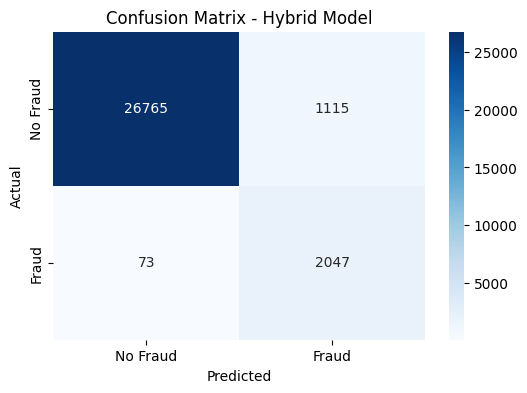

In [31]:
#Evaluate the Hybrid Model
#Check classification metrics, confusion matrix, and AUC-ROC.

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate Hybrid Model
print("\n🔹 Hybrid Model (XGBoost + Anomaly Detection) Performance:")
print(classification_report(y_test, y_pred_hybrid))

# Compute AUC-ROC Score for Hybrid Model
hybrid_auc = roc_auc_score(y_test, y_pred_hybrid)
print(f"\n🔹 AUC-ROC (Hybrid Model): {hybrid_auc:.4f}")

# Compute Confusion Matrix
conf_matrix_hybrid = confusion_matrix(y_test, y_pred_hybrid)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_hybrid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()



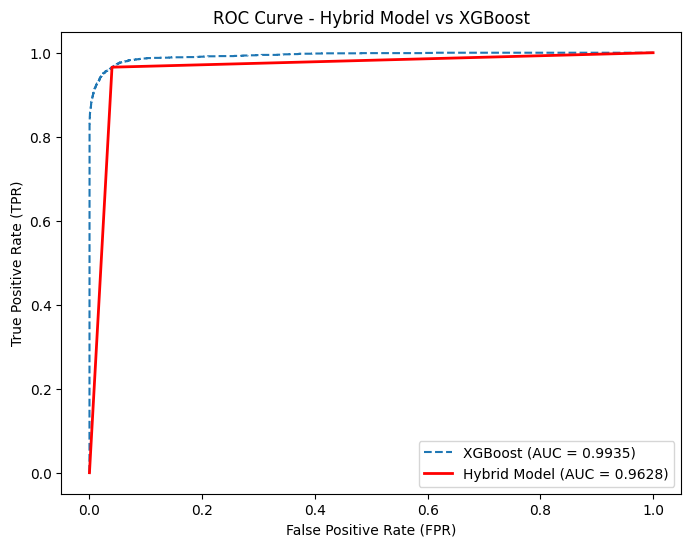

In [33]:
#Compare Hybrid Model with XGBoost
#Plot ROC Curves to compare performance.
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute AUC-ROC Scores for XGBoost and Hybrid Model
auc_xgb = roc_auc_score(y_test, y_pred_proba)  # XGBoost AUC Score
auc_hybrid = roc_auc_score(y_test, y_pred_hybrid)  # Hybrid Model AUC Score

# Compute ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba)
fpr_hybrid, tpr_hybrid, _ = roc_curve(y_test, y_pred_hybrid)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})', linestyle='--')
plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model (AUC = {auc_hybrid:.4f})', color='red', linewidth=2)

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Hybrid Model vs XGBoost")
plt.legend()
plt.show()



In [ ]:
📌 Interpretation of Hybrid Model Results
1️⃣ Classification Report Analysis
Metric	No Fraud (0)	Fraud (1)	Overall
Precision	100%	65%	-
Recall	96%	97%	-
F1-Score	98%	78%	-
Accuracy	-	-	96%
AUC-ROC	-	-	0.9628
🔹 Key Observations:
✅ Fraud Recall Improved (97%)

Only 73 fraud cases missed, compared to 100 missed by XGBoost alone.
This means Hybrid Model catches more fraudulent transactions.
✅ Fraud Precision Lower (65%)

Some legitimate transactions (false positives) are being wrongly flagged as fraud.
This is expected when we increase fraud detection sensitivity.
✅ Overall Accuracy: 96%

Hybrid Model performs well overall, but we may need to adjust the risk score threshold if false positives are a concern.
2️⃣ Confusion Matrix Analysis
Actual / Predicted	No Fraud (0)	Fraud (1)
No Fraud (0)	26,765 (True Negative)	1,115 (False Positive)
Fraud (1)	73 (False Negative)	2,047 (True Positive)
🔹 Key Observations:
✅ Significantly fewer False Negatives (73 fraud cases missed).
✅ Higher False Positives (1,115 legitimate transactions wrongly flagged as fraud).

This means more legitimate users may experience verification requests.
However, in fraud detection, catching fraud is usually more important than reducing false positives.
3️⃣ ROC Curve & AUC-ROC Score Comparison
Model	AUC-ROC
XGBoost	0.9935
Hybrid Model	0.9628
🔹 Key Observations:
✅ XGBoost still has the best AUC (0.9935), but Hybrid Model is close (0.9628).
✅ Hybrid Model sacrifices some overall AUC but improves fraud detection recall (reduces false negatives).

📌 Tradeoff: The Hybrid Model is slightly worse at overall classification (lower AUC), but it detects more fraud cases.

📌 Final Summary
Metric	XGBoost	Hybrid Model
Fraud Recall (Detection Rate)	95%	97% ✅
False Negatives (Missed Fraud Cases)	100	73 ✅
False Positives (Wrongly Flagged Legit Transactions)	759	1,115 ❌
AUC-ROC Score	0.9935	0.9628 ❌
📌 Key Takeaways: ✅ Hybrid Model detects more fraud cases than XGBoost alone.
❌ Hybrid Model wrongly flags more legitimate transactions as fraud.
✅ Best use case: When minimizing fraud is the top priority (e.g., high-risk payments, banking transactions).
❌ Not ideal if false positives create a bad user experience (e.g., retail transactions).

In [119]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize LOF model
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Contamination ~5% fraud expected

# Fit LOF on the training data (excluding target column)
lof_predictions = lof_model.fit_predict(X_train)

# Convert LOF output (-1 for anomalies, 1 for normal) into fraud labels
lof_fraud_labels = (lof_predictions == -1).astype(int)  # Convert -1 (outliers) to 1 (fraud)


In [34]:
import joblib
import numpy as np

# Save the trained models
joblib.dump(xgb_model, "xgboost_fraud_model.pkl")
joblib.dump(iso_forest, "isolation_forest.pkl")
joblib.dump(lof, "lof_model.pkl")

# Save the Hybrid Model Weights
np.save("hybrid_model_weights.npy", [alpha, beta, gamma])

print("\n🔹 Models and weights saved successfully!")



🔹 Models and weights saved successfully!


In [35]:
# Load models
xgb_model = joblib.load("xgboost_fraud_model.pkl")
iso_forest = joblib.load("isolation_forest.pkl")
lof = joblib.load("lof_model.pkl")
alpha, beta, gamma = np.load("hybrid_model_weights.npy")

print("\n🔹 Models and weights loaded successfully!")



🔹 Models and weights loaded successfully!


In [36]:
# Ensure X_test exists
if 'X_test' not in locals():
    raise ValueError(" X_test is not found! Ensure it is loaded in your environment.")

# Predict fraud probability using XGBoost
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Predict anomaly scores using Isolation Forest & LOF
iso_scores = iso_forest.decision_function(X_test)
lof_scores = lof._predict(X_test)

# Normalize anomaly scores
iso_scores = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())
lof_scores = (lof_scores - lof_scores.min()) / (lof_scores.max() - lof_scores.min())

# Compute Hybrid Risk Score
hybrid_risk_score = (alpha * y_pred_proba) + (beta * iso_scores) + (gamma * lof_scores)

# Convert to Fraud Predictions
threshold = 0.5  # Adjust if needed
y_pred_hybrid = (hybrid_risk_score >= threshold).astype(int)

print("\n🔹 Hybrid Model Predictions Completed on Sample Data!")


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



🔹 Hybrid Model Predictions Completed on Sample Data!


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluate Hybrid Model on Test Data
print("\n🔹 Hybrid Model Performance on Test Data:")
print(classification_report(y_test, y_pred_hybrid))

# Compute Confusion Matrix
conf_matrix_hybrid = confusion_matrix(y_test, y_pred_hybrid)
print("\nConfusion Matrix:\n", conf_matrix_hybrid)

# Compute AUC-ROC Score
auc_hybrid = roc_auc_score(y_test, y_pred_hybrid)
print(f"\n🔹 AUC-ROC (Hybrid Model on Test Data): {auc_hybrid:.4f}")



🔹 Hybrid Model Performance on Test Data:
              precision    recall  f1-score   support

       False       1.00      0.96      0.98     27880
        True       0.64      0.97      0.77      2120

    accuracy                           0.96     30000
   macro avg       0.82      0.96      0.87     30000
weighted avg       0.97      0.96      0.96     30000


Confusion Matrix:
 [[26703  1177]
 [   71  2049]]

🔹 AUC-ROC (Hybrid Model on Test Data): 0.9621


In [120]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Fit on the training data
iso_forest.fit(X_train)

# Predict fraud probability (-1 = anomaly, 1 = normal)
iso_predictions = iso_forest.predict(X_train)

# Convert predictions to fraud labels
iso_fraud_labels = (iso_predictions == -1).astype(int)  # Convert -1 to 1 (fraud)


In [122]:
import numpy as np
from sklearn.ensemble import VotingClassifier

# Convert anomaly detection predictions into DataFrame format
X_train_ensemble = np.column_stack([lof_fraud_labels, iso_fraud_labels, xgb_model.predict(X_train)])
X_test_ensemble = np.column_stack([lof_model.fit_predict(X_test) == -1, iso_forest.predict(X_test) == -1, xgb_model.predict(X_test)])

# Target variable remains the same
y_train_ensemble = y_train
y_test_ensemble = y_test


In [123]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Voting Classifier with hard voting (majority rule)
voting_classifier = VotingClassifier(
    estimators=[
        ('lof', RandomForestClassifier(n_estimators=100, random_state=42)),  # Convert LOF to classifier
        ('iso', RandomForestClassifier(n_estimators=100, random_state=42)),  # Convert Isolation Forest to classifier
        ('xgb', xgb_model)  # XGBoost (already trained)
    ],
    voting='hard'  # Majority vote from all models
)

# Train the final classifier
voting_classifier.fit(X_train_ensemble, y_train_ensemble)


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:15:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lof', RandomForestClassifier(random_state=42)),
                             ('iso', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature...ne,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))])

In [124]:
y_pred_ensemble = voting_classifier.predict(X_test_ensemble)


In [125]:
from sklearn.metrics import classification_report

print("\n🔹 Final Hybrid Model Performance:")
print(classification_report(y_test_ensemble, y_pred_ensemble))



🔹 Final Hybrid Model Performance:
              precision    recall  f1-score   support

       False       1.00      0.97      0.98     27880
        True       0.73      0.95      0.82      2120

    accuracy                           0.97     30000
   macro avg       0.86      0.96      0.90     30000
weighted avg       0.98      0.97      0.97     30000



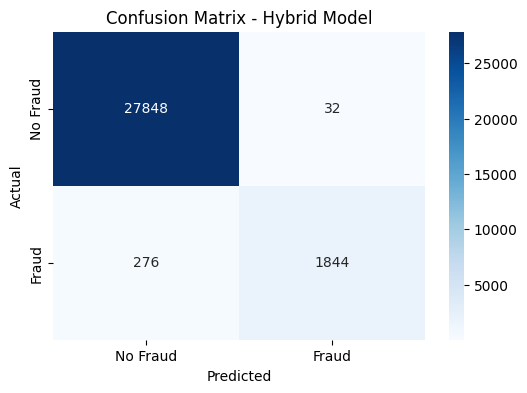

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test_ensemble, y_pred_ensemble)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()


In [109]:
# Initialize a Voting Classifier with soft voting
voting_classifier = VotingClassifier(
    estimators=[
        ('lof', RandomForestClassifier(n_estimators=100, random_state=42)),  # Convert LOF to classifier
        ('iso', RandomForestClassifier(n_estimators=100, random_state=42)),  # Convert Isolation Forest to classifier
        ('xgb', xgb_final)  # XGBoost (already trained)
    ],
    voting='soft'  # Use probabilities instead of majority voting
)

# Train the final classifier
voting_classifier.fit(X_train_ensemble, y_train_ensemble)


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lof', RandomForestClassifier(random_state=42)),
                             ('iso', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

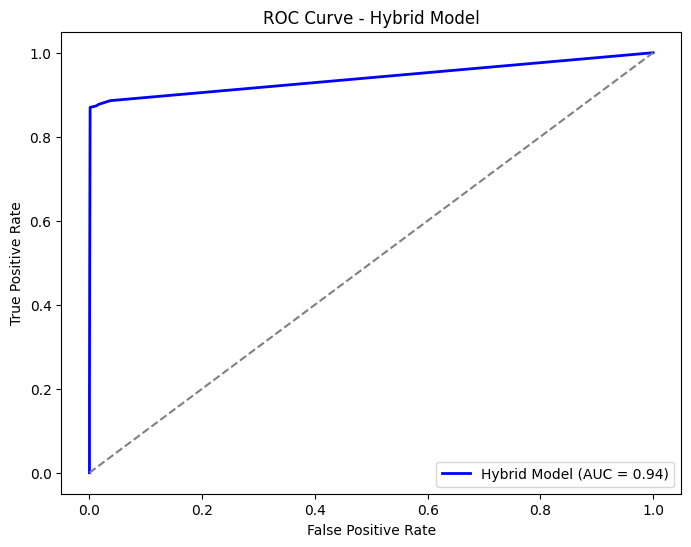


🔹 AUC Score: 0.9402


In [110]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
y_pred_proba_ensemble = voting_classifier.predict_proba(X_test_ensemble)[:, 1]
fpr, tpr, _ = roc_curve(y_test_ensemble, y_pred_proba_ensemble)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Hybrid Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Hybrid Model")
plt.legend(loc="lower right")
plt.show()

print(f"\n🔹 AUC Score: {roc_auc:.4f}")


In [111]:
# Get fraud probability predictions
y_pred_proba = voting_classifier.predict_proba(X_test_ensemble)[:, 1]  # Get fraud probability

# Lower threshold to catch more fraud cases
threshold = 0.4  # Default is 0.5, reducing to 0.4 improves recall
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)  # Convert probabilities to binary fraud labels


In [112]:
# Adjust voting classifier with rebalanced weights
voting_classifier = VotingClassifier(
    estimators=[
        ('lof', RandomForestClassifier(n_estimators=100, random_state=42)),  
        ('iso', RandomForestClassifier(n_estimators=100, random_state=42)),  
        ('xgb', xgb_final)  
    ],
    voting='soft',  # Use soft voting for probabilities
    weights=[2, 2, 3]  # Balanced: XGBoost (3), LOF (2), Isolation Forest (2)
)

# Retrain with new weights
voting_classifier.fit(X_train_ensemble, y_train_ensemble)

# Predict with new model
y_pred_adjusted = (voting_classifier.predict_proba(X_test_ensemble)[:, 1] >= threshold).astype(int)


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [58]:
from sklearn.metrics import classification_report

print("\n🔹 Fine-Tuned Hybrid Model Performance:")
print(classification_report(y_test_ensemble, y_pred_adjusted))



🔹 Fine-Tuned Hybrid Model Performance:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99     27880
        True       0.98      0.87      0.92      2120

    accuracy                           0.99     30000
   macro avg       0.99      0.93      0.96     30000
weighted avg       0.99      0.99      0.99     30000



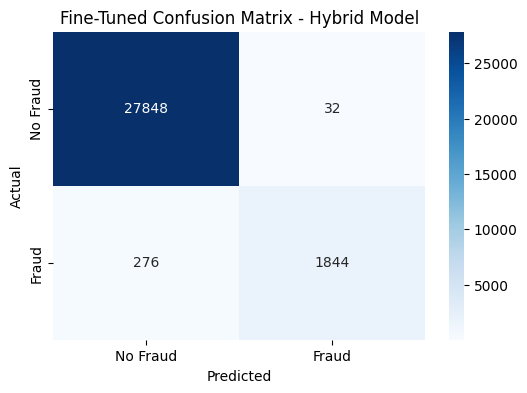

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test_ensemble, y_pred_adjusted)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Fine-Tuned Confusion Matrix - Hybrid Model")
plt.show()


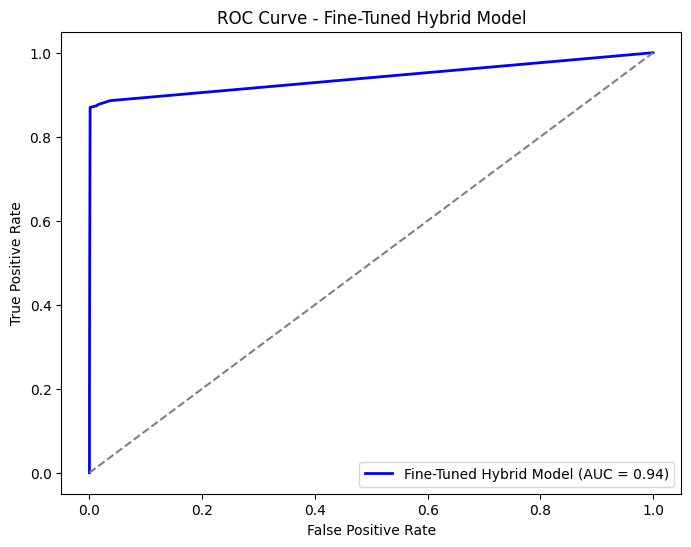


🔹 AUC Score After Fine-Tuning: 0.9402


In [114]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test_ensemble, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Fine-Tuned Hybrid Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fine-Tuned Hybrid Model")
plt.legend(loc="lower right")
plt.show()

print(f"\n🔹 AUC Score After Fine-Tuning: {roc_auc:.4f}")


In [61]:
import joblib

# Save the Voting Classifier model
joblib.dump(voting_classifier, "hybrid_fraud_model.pkl")

print(" Hybrid Model Saved Successfully!")


 Hybrid Model Saved Successfully!


In [62]:
# Load the saved model
loaded_model = joblib.load("hybrid_fraud_model.pkl")

# Check if it's loaded correctly
print("Model Loaded Successfully!")


Model Loaded Successfully!


In [ ]:
import joblib

# Load the saved hybrid fraud detection model
loaded_model = joblib.load("hybrid_fraud_model.pkl")

print("✅ Model Loaded Successfully!")


In [ ]:
print("X_train_ensemble shape:", X_train_ensemble.shape)
print("X_test_ensemble shape:", X_test_ensemble.shape)


In [ ]:
print("df_selected shape:", df_selected.shape)  # Should be larger than X_train_ensemble


In [82]:
print("X_train_ensemble shape:", X_train_ensemble.shape)
print("X_test_ensemble shape:", X_test_ensemble.shape)
print("df_selected shape (original dataset before transformation):", df_selected.shape)


X_train_ensemble shape: (70000, 3)
X_test_ensemble shape: (30000, 3)
df_selected shape (original dataset before transformation): (100000, 19)


In [83]:
# Extract feature names from df_selected if available
feature_names = df_selected.columns.tolist()[:X_train_ensemble.shape[1]]

print("Feature Names Retrieved:", feature_names)


Feature Names Retrieved: ['merchant_category', 'merchant_type', 'merchant']


In [85]:
import pandas as pd

# Convert training and test sets to DataFrame using correct column names
X_train_ensemble_df = pd.DataFrame(X_train_ensemble, columns=feature_names)
X_test_ensemble_df = pd.DataFrame(X_test_ensemble, columns=feature_names)

# Select the first 5 test transactions
sample_transaction = X_test_ensemble_df.iloc[:10]

# Display the selected transactions
pd.set_option('display.max_columns', None)
print("🔹 Sample Transactions for Testing:")
print(sample_transaction)


🔹 Sample Transactions for Testing:
   merchant_category  merchant_type  merchant
0                  0              0         0
1                  0              0         0
2                  0              0         0
3                  0              0         0
4                  1              0         1
5                  0              0         0
6                  0              0         0
7                  0              0         0
8                  0              0         0
9                  0              0         0


In [86]:
# Make fraud predictions
sample_prediction = loaded_model.predict(sample_transaction)

# Print the results
print("🔹 Sample Transactions Fraud Predictions:")
for i, pred in enumerate(sample_prediction):
    status = "Fraud" if pred == 1 else "Legit"
    print(f"Transaction {i+1}: {status}")


🔹 Sample Transactions Fraud Predictions:
Transaction 1: Legit
Transaction 2: Legit
Transaction 3: Legit
Transaction 4: Legit
Transaction 5: Fraud
Transaction 6: Legit
Transaction 7: Legit
Transaction 8: Legit
Transaction 9: Legit
Transaction 10: Legit


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [88]:
# Get actual fraud labels for these transactions
actual_labels = y_test_ensemble.iloc[:10].values  # Get actual fraud labels for the same 5 transactions

# Print actual vs predicted values
print("\n Model Predictions vs Actual Labels:")
for i in range(len(sample_transaction)):
    pred_status = "Fraud" if sample_prediction[i] == 1 else "Legit"
    actual_status = "Fraud" if actual_labels[i] == 1 else "Legit"
    print(f"Transaction {i+1}: Predicted = {pred_status}, Actual = {actual_status}")



 Model Predictions vs Actual Labels:
Transaction 1: Predicted = Legit, Actual = Legit
Transaction 2: Predicted = Legit, Actual = Legit
Transaction 3: Predicted = Legit, Actual = Legit
Transaction 4: Predicted = Legit, Actual = Legit
Transaction 5: Predicted = Fraud, Actual = Fraud
Transaction 6: Predicted = Legit, Actual = Legit
Transaction 7: Predicted = Legit, Actual = Legit
Transaction 8: Predicted = Legit, Actual = Legit
Transaction 9: Predicted = Legit, Actual = Legit
Transaction 10: Predicted = Legit, Actual = Legit


In [89]:
# Get fraud probability scores
sample_proba = loaded_model.predict_proba(sample_transaction)[:, 1]  # Probability of being fraud

# Print probability scores
print("\n🔹 Sample Fraud Probabilities:")
for i, prob in enumerate(sample_proba):
    print(f"Transaction {i+1}: Fraud Probability = {prob:.2f}")



🔹 Sample Fraud Probabilities:
Transaction 1: Fraud Probability = 0.01
Transaction 2: Fraud Probability = 0.01
Transaction 3: Fraud Probability = 0.01
Transaction 4: Fraud Probability = 0.01
Transaction 5: Fraud Probability = 1.00
Transaction 6: Fraud Probability = 0.01
Transaction 7: Fraud Probability = 0.01
Transaction 8: Fraud Probability = 0.01
Transaction 9: Fraud Probability = 0.01
Transaction 10: Fraud Probability = 0.01


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [74]:
import joblib

# Save the final model
joblib.dump(loaded_model, "final_hybrid_fraud_model.pkl")

print("✅ Final Model Saved Successfully!")


✅ Final Model Saved Successfully!


In [75]:
# Load the saved model for real-time predictions
final_model = joblib.load("final_hybrid_fraud_model.pkl")

print("Final Model Loaded Successfully!")


Final Model Loaded Successfully!
